In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random
from gymnasium import Env, spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points


class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(9)  # 8 moves + shoot
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width // 2)  # Start on left half
        ])
        self.shoot_speed = 6  # Increased shoot speed for longer shots
        self.shoot_speed_decay = 0.8  # Reduced decay for longer shots

    def policy(self, state, epsilon):
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            q_values = self.q_table[state, :]
            return np.argmax(q_values)

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width // 2)  # Start on left half
            ])
        return self.position

    def shoot_ball(self, current_position, goal_position):
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(goal_position[0]), int(goal_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([goal_position[0] - current_position[0], 
                             goal_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.shoot_speed, direction
    

class FootballEnv(Env):
    def __init__(self, field_height, field_width, agent):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)
        self.mid_field = self.field_width // 2  # Middle of the field

        # Observation Space: Combination of agent position and ball position
        # This creates a unique state for each possible combination
        self.observation_space = spaces.Discrete(field_height * field_width * field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -1, dtype=np.float32)
        
        # Goal area has a higher reward
        self.rewards[:, self.goal_y] = 10.0
        
        # Encourage staying on the left half for shooting practice
        for x in range(self.field_height):
            for y in range(self.mid_field, self.goal_y):
                distance_to_goal = self.goal_y - y
                # Higher negative reward in right half to discourage dribbling all the way
                self.rewards[x, y] = -2 - distance_to_goal * 0.5

        self.ball_holder = 0
        self.agent = agent
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0

        # Initialize Q-table with the expanded state space
        self.agent.q_table = np.zeros((self.observation_space.n, agent.action_space.n))

        self.reset()

    def reset(self, seed=None, options=None):
        self.agent.reset_position()
        
        # Spawn ball only in the left half of the pitch
        self.ball_pos = np.array([
            np.random.randint(0, self.field_height),
            np.random.randint(0, self.field_width // 2)  # Left half only
        ])
        
        self.ball_holder = 0
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.done = False

        if np.array_equal(self.agent.position, self.ball_pos):
            self.ball_holder = 1
            self.ball_pos = self.agent.position.copy()
            self.ball_in_transit = False

        return self._get_state_index()

    def _get_state_index(self):
        # Create a unique state index that combines agent position and ball position
        agent_pos_index = self.agent.position[0] * self.field_width + self.agent.position[1]
        ball_pos_index = self.ball_pos[0] * self.field_width + self.ball_pos[1]
        
        # Combine them into a single state index
        state_index = agent_pos_index * (self.field_height * self.field_width) + ball_pos_index
        return state_index
        
    def closest_goal_cell(self, agent_pos):
        # Select one cell from the goal area
        goal_cells = [(i, self.goal_y) for i in range(self.field_height)]
        
        # Calculate the "ideal" target based on shooting angle
        # Aim at the center of the goal when shooting from far away
        goal_center = self.field_height // 2
        
        # Get distance to goal
        distance_to_goal = self.goal_y - agent_pos[1]
        
        if distance_to_goal > self.field_width // 2:
            # If shooting from far away, aim at center of goal
            target = (goal_center, self.goal_y)
        else:
            # Otherwise, find the closest goal cell
            closest_cell = min(goal_cells, key=lambda cell: np.linalg.norm(np.array(agent_pos) - np.array(cell)))
            target = closest_cell
            
        return target
        
    def step(self, action):
        reward = 0  # Initialize rewards
        
        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Get the action for the agent
        if action in move_map:
            move = move_map[action]
            new_position = self.agent.position + move

            # Check if the new position is within bounds
            if (0 <= new_position[0] < self.field_height) and (0 <= new_position[1] < self.field_width):
                self.agent.position = new_position
                
                # If agent had the ball, the ball moves with the agent
                if self.ball_holder == 1:
                    self.ball_pos = self.agent.position.copy()
                
                # Check if the agent just got the ball
                elif self.ball_holder == 0 and np.array_equal(self.agent.position, self.ball_pos):
                    self.ball_holder = 1
                    self.ball_pos = self.agent.position.copy()
                    # Reward for picking up the ball
                    reward += 50
        
        elif action == 8:  # Shoot
            # Check if the agent is holding the ball
            if self.ball_holder == 1:
                closest_shot = self.closest_goal_cell(self.agent.position)
                
                # Extra reward for shooting from the left half (long distance)
                distance_to_goal = self.goal_y - self.agent.position[1]
                if self.agent.position[1] < self.mid_field:
                    # The further left, the higher the potential shooting reward
                    potential_shooting_bonus = 200 * (1 - self.agent.position[1] / self.mid_field)
                else:
                    potential_shooting_bonus = 0
                
                # Calculate the trajectory of the ball
                self.ball_trajectory, self.ball_transit_speed, self.ball_transit_direction = self.agent.shoot_ball(self.agent.position, closest_shot)
                self.ball_in_transit = True
                self.ball_holder = 0  # Ball is no longer held by the agent
                self.ball_trajectory_index = 0  # Reset trajectory index
                
                # Small reward just for shooting (risky action with potential payoff)
                if distance_to_goal > self.field_width // 2:
                    reward += 20  # Extra reward for long-range shots
                
        # Handle ball movement if in transit
        if self.ball_in_transit:
            # First apply speed decay at the beginning of the step
            if self.ball_transit_speed <= 0:
                self.ball_in_transit = False
                self.ball_transit_speed = 0
            else:
                self.ball_transit_speed -= self.agent.shoot_speed_decay
                
            # If ball is still in transit after speed decay
            if self.ball_in_transit:
                # Calculate how many steps to move based on current speed
                steps_to_move = max(1, int(round(self.ball_transit_speed)))
                
                # Move the ball along its trajectory by the number of steps determined by speed
                for _ in range(steps_to_move):
                    if self.ball_trajectory_index < len(self.ball_trajectory):
                        # Get the next position from the trajectory
                        next_pos = self.ball_trajectory[self.ball_trajectory_index]
                        self.ball_pos = np.array(next_pos)
                        self.ball_trajectory_index += 1
                        
                        # Check if ball reached the goal
                        if self.ball_pos[1] == self.goal_y:
                            # Calculate goal reward based on shooting distance
                            shot_distance = self.goal_y - self.agent.position[1]
                            distance_factor = min(3.0, max(1.0, shot_distance / (self.field_width // 2)))
                            goal_reward = 1000 * distance_factor  # Higher reward for longer shots
                            
                            # Add goal reward + field reward
                            field_reward = self.rewards[self.ball_pos[0], self.ball_pos[1]]
                            total_reward = goal_reward + field_reward
                            reward += total_reward
                            
                            print(f"Goal from distance {shot_distance}! Reward: {total_reward:.1f}")
                            self.ball_holder = 0  # Ball is no longer held by the agent
                            self.done = True  # End the episode on goal
                            self.ball_in_transit = False
                            break
                    else:
                        # Ball has completed its trajectory
                        self.ball_in_transit = False
                        self.ball_transit_speed = 0
                        break
                        
                # Check if any agent is at the ball's position after movement
                if not self.ball_in_transit and np.array_equal(self.agent.position, self.ball_pos):
                    self.ball_holder = 1  # Agent reclaims the ball
                    reward += 20  # Additional reward for reclaiming the ball after shooting
        
        # Calculate distance-based reward to encourage moving toward the ball
        if self.ball_holder == 0 and not self.ball_in_transit:
            # Calculate distance to ball
            distance_to_ball = np.linalg.norm(self.agent.position - self.ball_pos)
            # Small reward for being closer to the ball
            proximity_reward = -0.1 * distance_to_ball
            reward += proximity_reward
            
        # Only add field reward if we haven't already scored a goal (to avoid double counting)
        if not self.done:
            # Get the current state reward from the rewards matrix
            state_reward = self.rewards[self.agent.position[0], self.agent.position[1]]
            reward += state_reward
        
        # Return the new state, reward, and done flag
        return self._get_state_index(), reward, self.done, {}
    
    def train(self, num_episodes, max_steps=200, epsilon_start=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.1):
        state = self.reset()
        episode_rewards = []
        epsilon = epsilon_start  # Start with a high exploration rate
        
        for episode in range(num_episodes):
            state = self.reset()
            done = False
            total_reward = 0
            steps = 0
            
            while not done and steps < max_steps:
                # Choose action using epsilon-greedy policy
                action = self.agent.policy(state, epsilon)
                
                # Take a step in the environment
                next_state, reward, done, _ = self.step(action)
                total_reward += reward
                
                # Q-learning update
                best_next_action = np.argmax(self.agent.q_table[next_state])
                td_target = reward + gamma * self.agent.q_table[next_state, best_next_action] * (not done)
                td_error = td_target - self.agent.q_table[state, action]
                self.agent.q_table[state, action] += learning_rate * td_error
                
                state = next_state
                steps += 1
                
            # Decay epsilon after each episode
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            
            # Print progress
            if (episode + 1) % 100 == 0:
                goals_scored = sum(1 for r in episode_rewards[-100:] if r > 500)
                print(f"Episode {episode + 1}/{num_episodes}, Steps: {steps}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}")
                print(f"Goals in last 100 episodes: {goals_scored}/100")
                
            episode_rewards.append(total_reward)
            
        return episode_rewards

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # Mark the midfield line
        field_copy[:, self.mid_field] = '|'
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder == 0:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # render 'A' for agent
        field_copy[self.agent.position[0], self.agent.position[1]] = 'A'
        
        # If agent has the ball, show it as '@'
        if self.ball_holder == 1:
            field_copy[self.agent.position[0], self.agent.position[1]] = '@'
            
        # render 'G' for goal area
        field_copy[:, self.goal_y] = 'G'
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.' or field_copy[x, y] == '|':  # Don't overwrite agents or ball
                            field_copy[x, y] = '*'

        print("\n".join(["".join(row) for row in field_copy]) + "\n")
        print(f"Ball holder: {'Agent' if self.ball_holder == 1 else 'None'}")
        print(f"Agent position: {self.agent.position}")
        print(f"Ball position: {self.ball_pos}")
        
        # Show distance to goal if agent has the ball
        if self.ball_holder == 1:
            distance_to_goal = self.goal_y - self.agent.position[1]
            print(f"Distance to goal: {distance_to_goal}")

Initial State:
...B...|......G
.......|......G
.......|......G
.......|......G
.......|......G
.......|......G
....A..|......G
.......|......G
.......|......G
.......|......G

Ball holder: None
Agent position: [6 4]
Ball position: [0 3]
Goal from distance 10! Reward: 1438.6
Goal from distance 7! Reward: 1010.0
Goal from distance 7! Reward: 1010.0
Goal from distance 9! Reward: 1295.7
Goal from distance 1! Reward: 1010.0
Goal from distance 9! Reward: 1295.7
Goal from distance 1! Reward: 1010.0
Goal from distance 5! Reward: 1010.0
Goal from distance 0! Reward: 1010.0
Goal from distance 0! Reward: 1010.0
Goal from distance 0! Reward: 1010.0
Goal from distance 2! Reward: 1010.0
Goal from distance 1! Reward: 1010.0
Episode 100/100000, Steps: 12, Total Reward: 977.90, Epsilon: 0.1000
Goals in last 100 episodes: 96/100
Goal from distance 11! Reward: 1581.4
Goal from distance 11! Reward: 1581.4
Goal from distance 0! Reward: 1010.0
Goal from distance 0! Reward: 1010.0
Episode 200/100000, Steps: 

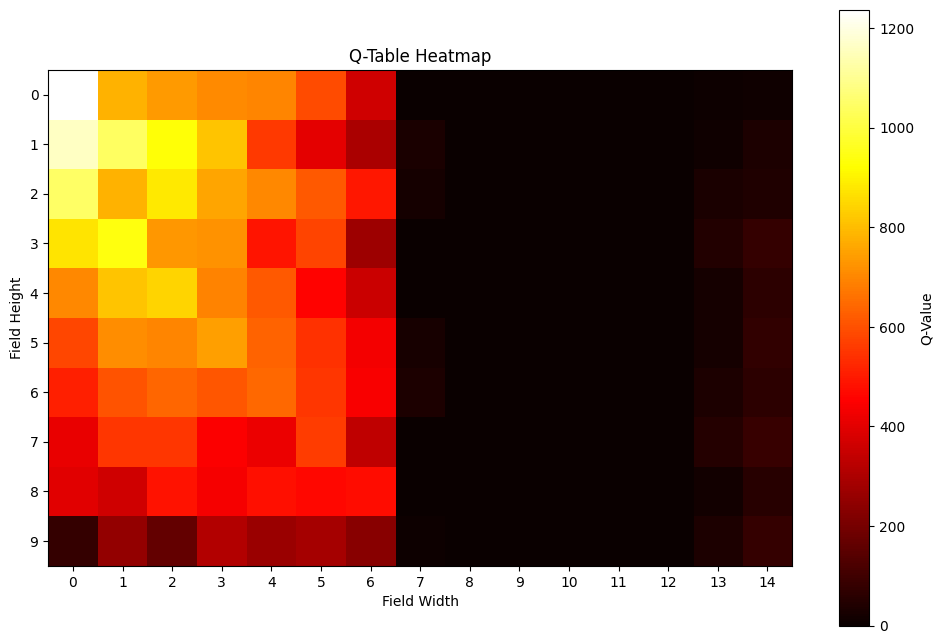

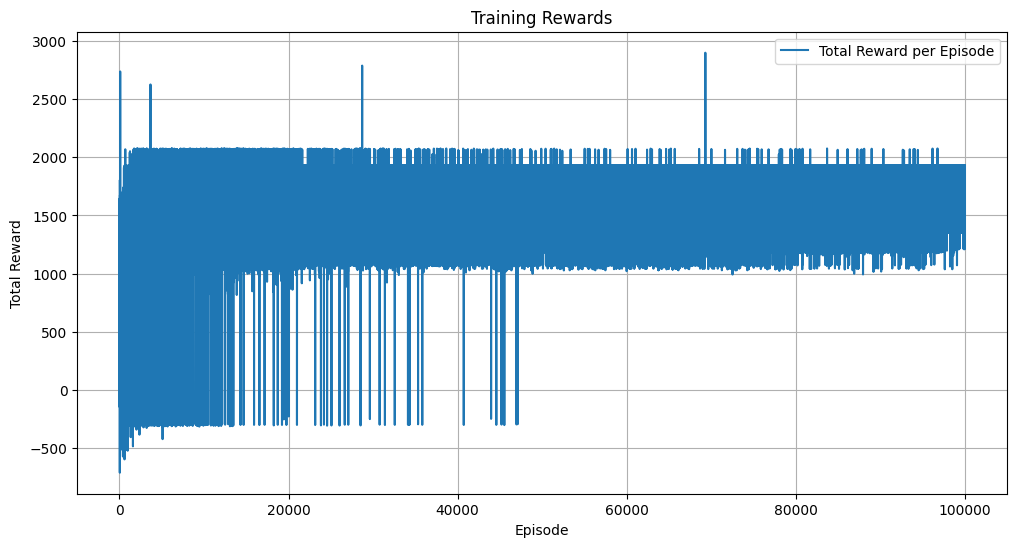

In [12]:
# Initialize the environment
field_height = 10
field_width = 15
agent = Agent(field_height, field_width)  # Start in the middle of the field
env = FootballEnv(field_height, field_width, agent)

# Dry run for a few steps
state = env.reset()
print("Initial State:")
env.render()

rewards = env.train(num_episodes=100000, max_steps=200 ,epsilon_decay=0.9, min_epsilon=0.1, gamma=0.9, learning_rate=0.1)

# reshape and plot q table
ball_pos_fixed = (0, 0)
ball_state_index = ball_pos_fixed[0] * field_width + ball_pos_fixed[1]

# Extract Q-values for the specific ball position
q_values_subset = []
for agent_x in range(field_height):
    for agent_y in range(field_width):
        agent_pos_index = agent_x * field_width + agent_y
        state_index = agent_pos_index * (field_height * field_width) + ball_state_index
        q_values_subset.append(agent.q_table[state_index])

# Reshape for visualization based on agent positions only
q_table_subset = np.array(q_values_subset).reshape(field_height, field_width, agent.action_space.n)

# Now plot this subset
plt.figure(figsize=(12, 8))
plt.title("Q-Table Heatmap")
plt.imshow(np.max(q_table_subset, axis=2), cmap='hot', interpolation='nearest')
plt.colorbar(label='Q-Value')
plt.xlabel('Field Width')
plt.ylabel('Field Height')
plt.xticks(np.arange(field_width), np.arange(field_width))
plt.yticks(np.arange(field_height), np.arange(field_height))
plt.grid(False)
plt.show()

# Plot the rewards over episodes
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()
plt.grid()
plt.show()

Training the agent...
Goal from distance 5! Reward: 1010.0
Goal from distance 12! Reward: 1724.3
Goal from distance 11! Reward: 1581.4
Goal from distance 14! Reward: 2010.0
Goal from distance 14! Reward: 2010.0
Goal from distance 10! Reward: 1438.6
Goal from distance 9! Reward: 1295.7
Goal from distance 8! Reward: 1152.9
Goal from distance 11! Reward: 1581.4
Goal from distance 11! Reward: 1581.4
Goal from distance 7! Reward: 1010.0
Goal from distance 9! Reward: 1295.7
Goal from distance 10! Reward: 1438.6
Goal from distance 13! Reward: 1867.1
Goal from distance 6! Reward: 1010.0
Goal from distance 14! Reward: 2010.0
Goal from distance 6! Reward: 1010.0
Goal from distance 8! Reward: 1152.9
Goal from distance 10! Reward: 1438.6
Goal from distance 8! Reward: 1152.9
Goal from distance 9! Reward: 1295.7
Goal from distance 2! Reward: 1010.0
Goal from distance 0! Reward: 1010.0
Goal from distance 10! Reward: 1438.6
Goal from distance 11! Reward: 1581.4
Goal from distance 12! Reward: 1724.3
Go

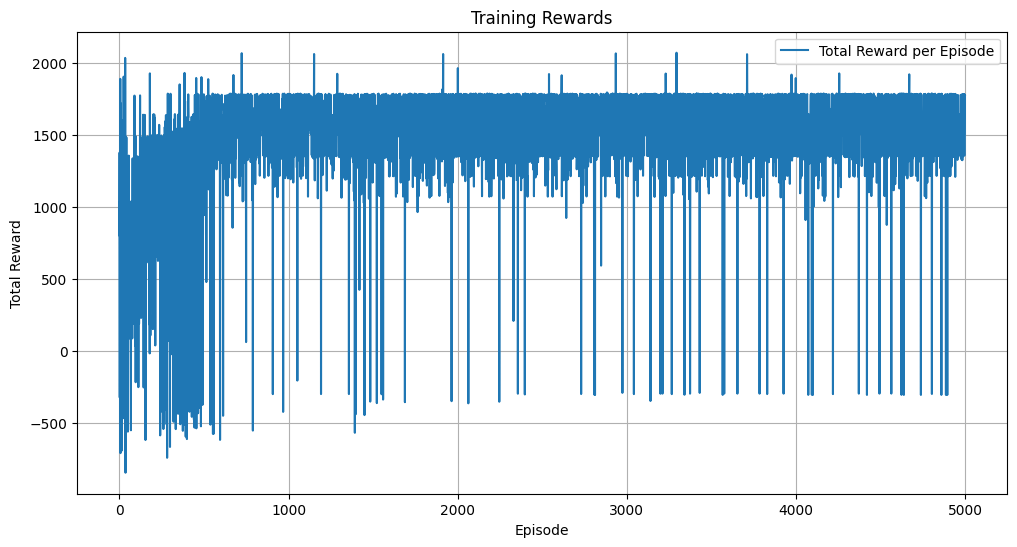


Evaluating trained agent...

Evaluation Episode 1/3
Step 1, Action: Right
Step 2, Action: Down
Step 3, Action: Down-Right
Shot taken from distance: 12


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_9968\1312200436.py:71: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 4, Action: Shoot
Step 5, Action: Left
Goal from distance 12! Reward: 1724.3
Step 6, Action: Right
Episode 1 finished after 6 steps with reward: 1787.72
GOAL SCORED from distance 12!

Evaluation Episode 2/3
Step 1, Action: Down
Step 2, Action: Down-Right
Step 3, Action: Down-Right
Step 4, Action: Down-Right
Step 5, Action: Down-Left
Step 6, Action: Left
Step 7, Action: Up-Left
Step 8, Action: Down-Left
Shot taken from distance: 14
Step 9, Action: Shoot
Step 10, Action: Up-Left
Step 11, Action: Down-Right
Goal from distance 12! Reward: 1724.3
Step 12, Action: Right
Episode 2 finished after 12 steps with reward: 1780.64
GOAL SCORED from distance 14!

Evaluation Episode 3/3
Step 1, Action: Up
Step 2, Action: Up
Step 3, Action: Left
Step 4, Action: Down-Left
Step 5, Action: Shoot
Step 6, Action: Shoot
Step 7, Action: Shoot
Step 8, Action: Shoot
Step 9, Action: Shoot
Step 10, Action: Shoot
Step 11, Action: Shoot
Step 12, Action: Shoot
Step 13, Action: Shoot
Step 14, Action: Shoot
Step 1

[1787.7165266738475, 1780.6365408485417, -85.14940174998414]

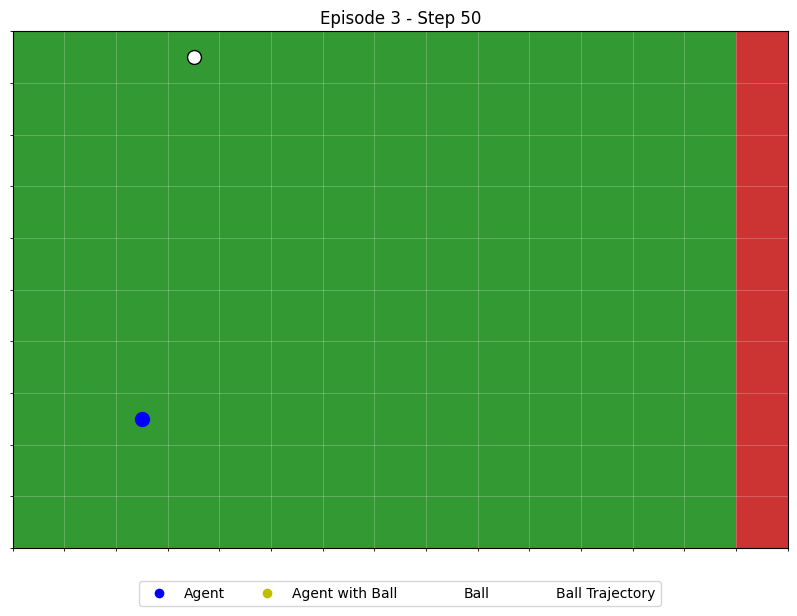

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import io
import time

def render_football_frame(env, ax, fig, episode, step_count, done=False):
    """Render the football environment as a matplotlib frame for the animation"""
    ax.clear()
    
    # Create a grid representing the field
    field = np.zeros((env.field_height, env.field_width, 3))  # RGB array
    
    # Green background for the field
    field[:, :] = [0.2, 0.6, 0.2]  # Green color
    
    # Goal area
    field[:, env.goal_y] = [0.8, 0.2, 0.2]  # Red color for goal
    
    # Draw the field
    ax.imshow(field, origin='upper')
    
    # Draw the ball
    if env.ball_holder == 0:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'wo', markersize=10, markeredgecolor='black')
    
    # Draw the agent
    if env.ball_holder == 1:
        # Agent with ball (different color)
        ax.plot(env.agent.position[1], env.agent.position[0], 'yo', markersize=12, markeredgecolor='black')
    else:
        # Agent without ball
        ax.plot(env.agent.position[1], env.agent.position[0], 'bo', markersize=10)
    
    # If ball is in transit, show trajectory
    if env.ball_in_transit and env.ball_trajectory:
        # Show remaining trajectory
        trajectory = np.array(env.ball_trajectory[env.ball_trajectory_index:])
        if len(trajectory) > 0:
            ax.plot(trajectory[:, 1], trajectory[:, 0], 'w--', linewidth=1.5, alpha=0.7)
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, env.field_width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.field_height, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Remove regular ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add episode and step information
    status = "GOAL!" if done else f"Step {step_count}"
    ax.set_title(f"Episode {episode+1} - {status}")
    
    # Add legend for elements
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', 
                  markersize=8, label='Agent'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='y', 
                  markersize=8, label='Agent with Ball'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='w', 
                  markersize=8, label='Ball'),
        plt.Line2D([0], [0], color='w', linestyle='--', label='Ball Trajectory')
    ]
    ax.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    # Convert plot to image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

def evaluate_with_animation(env, num_episodes=5, max_steps=100, output_gif="football_evaluation.gif"):
    """
    Evaluate the trained agent and create a GIF animation.
    
    Args:
        env: The football environment
        num_episodes: Number of episodes to evaluate
        max_steps: Maximum steps per episode
        output_gif: Filename for output GIF
        
    Returns:
        List of rewards per episode
    """
    episode_rewards = []
    goals_scored = 0
    shooting_distances = []
    
    # Setup for animation
    fig, ax = plt.subplots(figsize=(10, 7))
    frames = []
    
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        shot_taken = False
        shot_distance = 0
        
        print(f"\nEvaluation Episode {episode + 1}/{num_episodes}")
        
        while not done and steps < max_steps:
            # Use the policy with epsilon=0 (no exploration)
            action = env.agent.policy(state, epsilon=0)
            
            # Check if this action is a shoot action
            if action == 8 and env.ball_holder == 1:
                shot_taken = True
                shot_distance = env.goal_y - env.agent.position[1]
                print(f"Shot taken from distance: {shot_distance}")
            
            # Take step in environment
            next_state, reward, done, _ = env.step(action)
            
            # Update for next iteration
            state = next_state
            total_reward += reward
            steps += 1
            
            # Capture frame for animation
            frame = render_football_frame(env, ax, fig, episode, steps, done)
            frames.append(frame)
            
            # Optional: print action info
            action_names = {
                0: "Right", 1: "Down-Right", 2: "Down", 3: "Down-Left", 
                4: "Left", 5: "Up-Left", 6: "Up", 7: "Up-Right", 8: "Shoot"
            }
            print(f"Step {steps}, Action: {action_names.get(action, str(action))}")
        
        print(f"Episode {episode + 1} finished after {steps} steps with reward: {total_reward:.2f}")
        
        # Check if goal was scored
        if done and total_reward > 500:
            print(f"GOAL SCORED from distance {shot_distance}!")
            goals_scored += 1
            if shot_taken:
                shooting_distances.append(shot_distance)
        else:
            print("Max steps reached without scoring.")
            
        episode_rewards.append(total_reward)
        
        # Add a final frame showing the result
        final_frame = render_football_frame(env, ax, fig, episode, steps, done)
        frames.append(final_frame)
        
        # Add pause between episodes
        for _ in range(5):
            frames.append(final_frame)
    
    # Print summary
    print("\nEvaluation Summary:")
    print(f"Average reward over {num_episodes} episodes: {sum(episode_rewards)/len(episode_rewards):.2f}")
    print(f"Goals scored: {goals_scored}/{num_episodes} ({goals_scored/num_episodes*100:.1f}%)")
    
    if shooting_distances:
        avg_distance = sum(shooting_distances) / len(shooting_distances)
        print(f"Average shooting distance for goals: {avg_distance:.2f}")
    
    # Save frames as GIF
    if frames:
        print(f"Creating GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    return episode_rewards

# Use the main code with our improved visualization
field_height = 10
field_width = 15
agent = Agent(field_height, field_width)
env = FootballEnv(field_height, field_width, agent)

# Train the agent
print("Training the agent...")
rewards = env.train(num_episodes=5000, max_steps=200, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.1)

# Plot training rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()
plt.grid()
plt.show()
plt.close()

# Evaluate the trained agent with animation
print("\nEvaluating trained agent...")
evaluate_with_animation(env, num_episodes=3, max_steps=50, output_gif="shooting_evaluation.gif")